In [310]:
import folium
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame, Series

from folium.plugins import HeatMap

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [311]:
df: DataFrame = pd.read_csv('data/moscow_apartment_listings.csv')
df.head()

,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,...,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor,AO,hm
0,8000000,3,0,42,59,960,0.0,55.609009,37.734632,17166,...,5,1.0,1,39.4,11,12,0,0,UAO,panel
1,7200000,2,0,43,59,802,0.0,55.608760,37.741936,17166,...,9,1.0,1,35.6,2,9,0,0,UAO,panel
2,10300000,2,0,43,59,638,0.0,55.610207,37.742495,17166,...,9,2.0,2,53.0,5,12,0,0,UAO,panel
3,8500000,2,0,43,59,929,0.0,55.624017,37.740373,17166,...,5,1.0,2,44.1,8,9,0,0,UAO,panel
4,9000000,2,0,43,59,785,0.0,55.609107,37.740430,17166,...,5,1.0,2,44.2,6,9,0,0,UAO,panel


## Проверка данных

In [312]:
# Проверка наличия пропущенных значений
missing_values: Series = df.isnull().sum()
df_info: DataFrame = df.info()
df_info = df.info()
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12181 entries, 0 to 12180
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12181 non-null  int64  
 1   repair                 12181 non-null  int64  
 2   year_built_empty       12181 non-null  int64  
 3   house_age              12181 non-null  int64  
 4   closest_subway         12181 non-null  int64  
 5   dist_to_subway         12181 non-null  int64  
 6   sg                     12181 non-null  float64
 7   lat                    12181 non-null  float64
 8   lon                    12181 non-null  float64
 9   subway_dist_to_center  12181 non-null  int64  
 10  h3                     12181 non-null  object 
 11  agent_offers           12181 non-null  int64  
 12  subway_offers          12181 non-null  int64  
 13  address_offers         12181 non-null  float64
 14  rooms                  12181 non-null  int64  
 15  fo

price                    0
repair                   0
year_built_empty         0
house_age                0
closest_subway           0
dist_to_subway           0
sg                       0
lat                      0
lon                      0
subway_dist_to_center    0
h3                       0
agent_offers             0
subway_offers            0
address_offers           0
rooms                    0
footage                  0
floor                    0
max_floor                0
first_floor              0
last_floor               0
AO                       0
hm                       0
dtype: int64

#### Вывод:
    year_built_empty могут содержать мало информации или быть неясными. Нам нужно оценить их значимость для модели.
    Колонки h3, AO, и hm являются категориальными.
    Необходимо в будущем нормализовать данные

## Визуализация нашего датасета

In [313]:
map_moscow = folium.Map(location=[55.7558, 37.6173], zoom_start=10)  # координаты центра Москвы

# Подготовка данных для тепловой карты
heat_data = [[row['lat'], row['lon'], row['price']] for index, row in df.iterrows()]

# Добавление тепловой карты к карте
HeatMap(heat_data).add_to(map_moscow)

# Сохранение или отображение карты
map_moscow.save('web/moscow_heatmap.html')
map_moscow

In [314]:
"""
 UVAO    2053 +
 ZAO     1594 +
 UAO     1496 +
 UZAO    1453 +
 SAO     1422 +
 SVAO    1388 +
 VAO     1362 +
 SZAO     760 +
 CAO      653 +
"""

"""
['Южный', +
 'Юго-Восточный', +
 'Западный', +
 'Троицкий',
 'Новомосковский',
 'Северо-Западный', +
 'Центральный', +
 'Северо-Восточный', +
 'Юго-Западный', +
 'Зеленоградский',
 'Северный', +
 'Восточный' +]
"""
translation_dict = {
    'UVAO': 'Юго-Восточный',
    'ZAO': 'Западный',
    'UAO': 'Южный',
    'UZAO': 'Юго-Западный',
    'SAO' : 'Северный',
    'SVAO' : 'Северо-Восточный',
    'VAO' : 'Восточный',
    'SZAO' : 'Северо-Западный',
    'CAO' : 'Центральный',
}

geo_path = 'data/ao.geojson'
with open(geo_path) as f:
    geo_data = json.load(f)

df_copy = df.copy()
df_copy['AO'] = df_copy['AO'].map(translation_dict)

average_prices = df_copy.groupby('AO')['price'].mean().reset_index()
average_prices.rename(columns={'AO': 'NAME', 'price': 'average_price'}, inplace=True)
    
map_moscow = folium.Map(location=[55.7558, 37.6173], zoom_start=10)

folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=average_prices,
    columns=['NAME', 'average_price'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Средняя цена недвижимости по округам'
).add_to(map_moscow)

folium.LayerControl().add_to(map_moscow)

map_moscow.save('web/moscow_avg_price.html')
map_moscow

# Визуализация распределения ключевых переменных

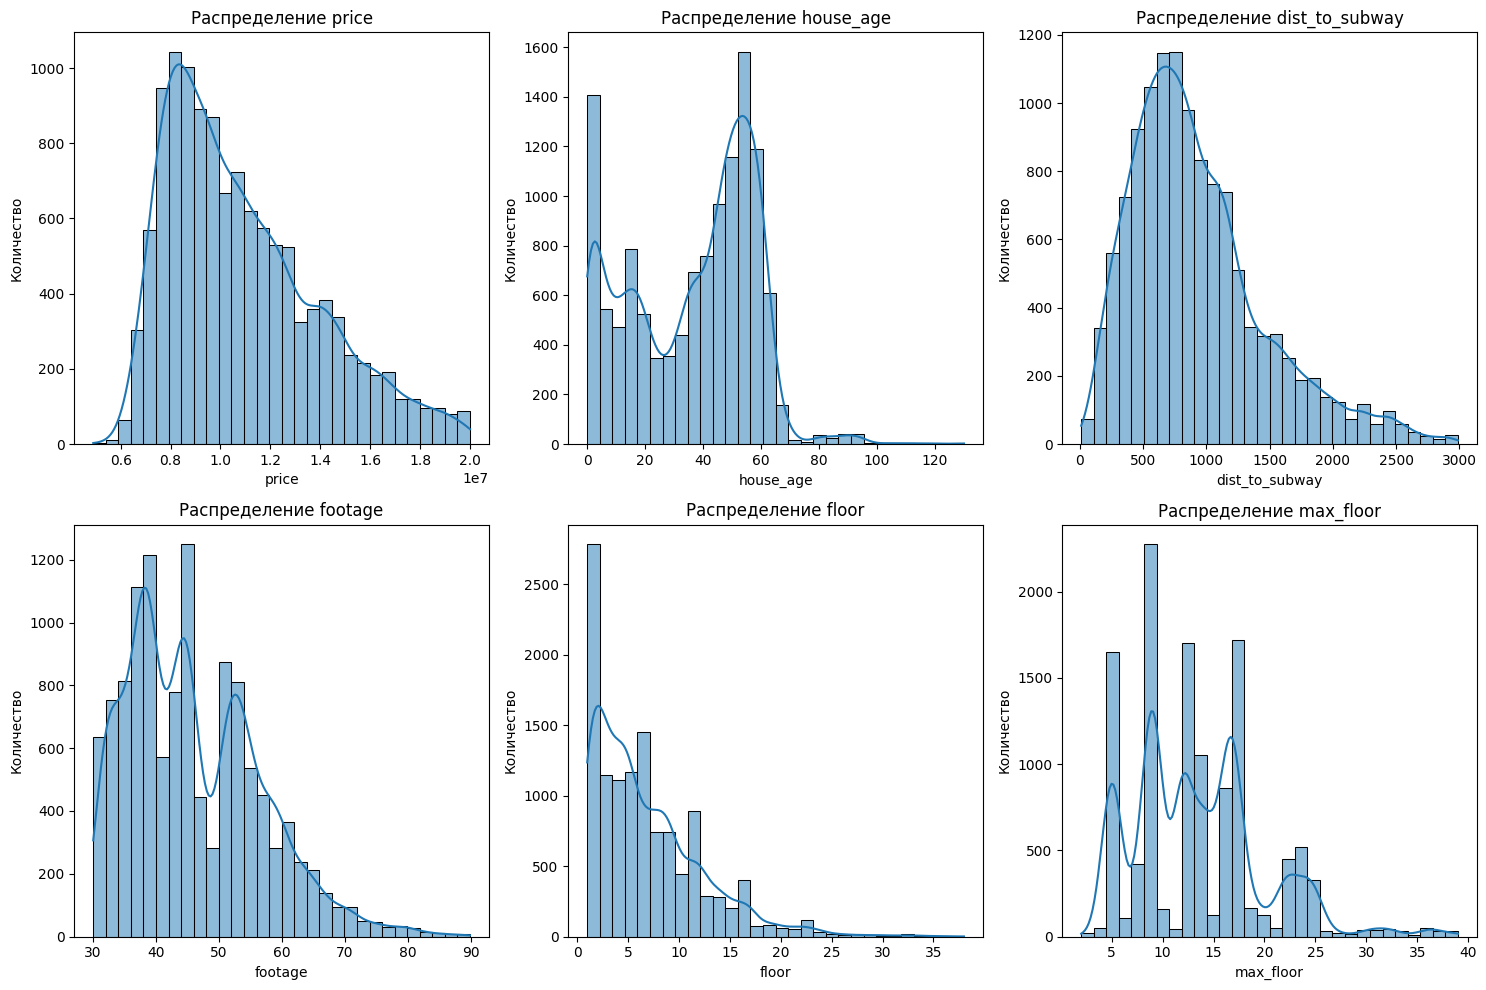

In [315]:
# Определение числовых колонок для анализа
numeric_columns = ['price', 'house_age', 'dist_to_subway', 'footage', 'floor', 'max_floor']


plt.figure(figsize=(15, 10))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')

plt.tight_layout()
plt.show()

#### Вывод:
    price: Распределение цен имеет длинный правый хвост, что указывает на наличие дорогих квартир.
    house_age: Распределение возраста домов показывает, что большинство домов имеют средний возраст.
    dist_to_subway: Распределение расстояния до метро скошено вправо, большинство квартир находятся относительно близко к метро.
    footage: Распределение площади квартир также имеет правостороннюю асимметрию.
    floor и max_floor: Распределение этажей и максимальных этажей в домах показывает, что большинство домов имеют не очень много этажей.

## Описательный анализ

### Просмотр основных статических показателей

In [316]:
df_description = df.describe()
df_description

,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,agent_offers,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor
count,1.218100e+04,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000
mean,1.086987e+07,2.267302,0.013710,36.360644,100.585009,928.353748,0.242673,55.738639,37.618241,11938.048026,25.429932,10.176915,1.290124,1.603973,46.153803,6.867334,13.449306,0.104671,0.094409
std,3.037320e+06,0.787196,0.116289,21.406406,56.707817,532.443508,0.629897,0.087598,0.134112,4711.729983,61.837916,7.078888,0.730561,0.489090,10.543171,5.313950,6.413437,0.306142,0.292409
min,4.900000e+06,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,55.527631,37.306055,1133.000000,0.000000,1.000000,1.000000,1.000000,30.100000,1.000000,2.000000,0.000000,0.000000
25%,8.500000e+06,2.000000,0.000000,17.000000,55.000000,548.000000,0.000000,55.674840,37.520435,8635.000000,1.000000,5.000000,1.000000,1.000000,38.000000,3.000000,9.000000,0.000000,0.000000
50%,1.020000e+07,2.000000,0.000000,42.000000,103.000000,820.000000,0.000000,55.730855,37.604411,12418.000000,1.000000,8.000000,1.000000,2.000000,44.500000,5.000000,12.000000,0.000000,0.000000
75%,1.270000e+07,3.000000,0.000000,54.000000,149.000000,1177.000000,0.000000,55.806115,37.720789,14800.000000,11.000000,13.000000,1.000000,2.000000,53.400000,9.000000,17.000000,0.000000,0.000000
max,2.000000e+07,4.000000,1.000000,130.000000,199.000000,2988.000000,3.000000,55.941577,37.950668,24636.000000,292.000000,40.000000,9.000000,2.000000,89.900000,38.000000,39.000000,1.000000,1.000000


#### Микровывод:
    Цена (price): Средняя цена квартиры составляет примерно 10.87 миллиона рублей, со стандартным отклонением 3.04 миллиона рублей. Минимальная цена - 4.9 миллиона рублей, максимальная - 20 миллионов рублей.

    Состояние ремонта (repair): Среднее значение состояния ремонта близко к 2, что указывает на то, что большинство квартир имеют среднее качество ремонта.

    Возраст дома (house_age): Средний возраст дома составляет около 36 лет, со стандартным отклонением в 21 год.

    Расстояние до метро (dist_to_subway): В среднем квартиры находятся на расстоянии около 928 метров от метро.

    Площадь квартир (footage): Средняя площадь квартиры составляет около 46 квадратных метров.

    Этаж (floor) и максимальное количество этажей (max_floor): Средний этаж, на котором расположена квартира, - это 7-й этаж, при этом в здании в среднем 13 этажей.

    Количество комнат (rooms): Большинство квартир имеют 1 или 2 комнаты.

### Анализ распределения переменных

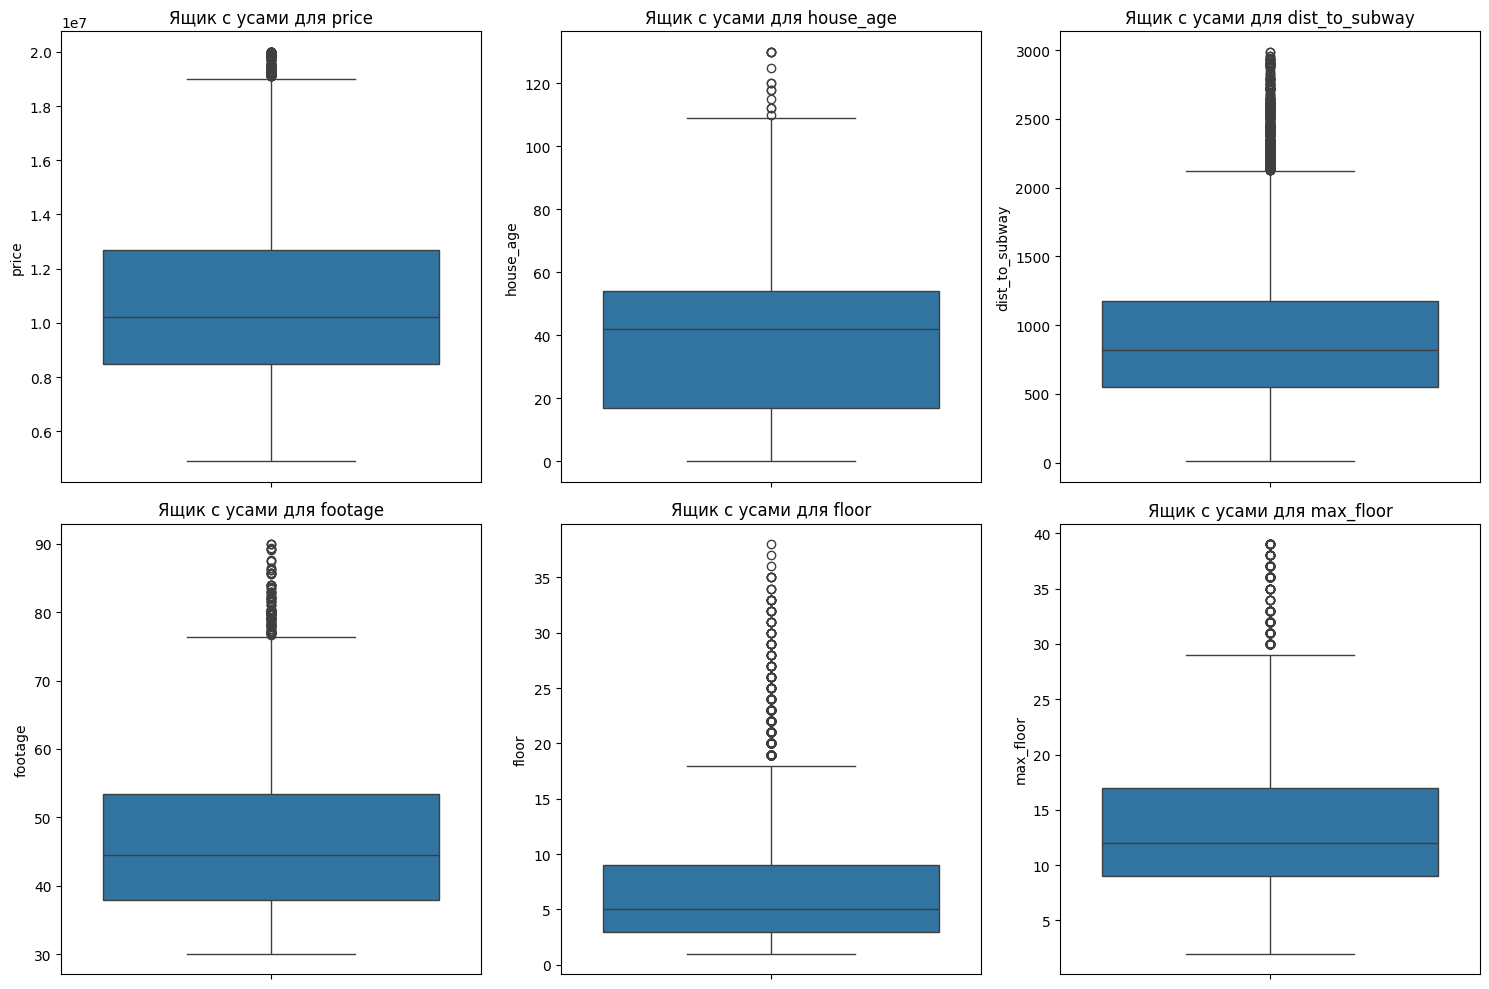

In [317]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Ящик с усами для {column}')

plt.tight_layout()
plt.show()

#### Микровывод:
    Все переменные, особенно price и footage, имеют выбросы.

### Анализ категориальных переменных

In [318]:
categorical_columns = ['h3', 'AO', 'hm', 'year_built_empty']

categorical_analysis = {col: df[col].value_counts() for col in categorical_columns}

categorical_analysis

{'h3': h3
 8611aa6a7ffffff    671
 8611aa7b7ffffff    602
 8611aa70fffffff    581
 8611aa717ffffff    544
 861181b6fffffff    534
 8611aa707ffffff    511
 8611aa787ffffff    500
 8611aa6b7ffffff    497
 8611aa637ffffff    473
 8611aa78fffffff    469
 8611aa71fffffff    456
 8611aa627ffffff    453
 8611aa797ffffff    401
 8611aa45fffffff    394
 8611aa68fffffff    351
 8611aa7a7ffffff    351
 8611aa617ffffff    329
 8611aa79fffffff    319
 8611aa4dfffffff    316
 861181b67ffffff    316
 8611aa7afffffff    311
 8611aa44fffffff    286
 8611aa6afffffff    273
 8611aa61fffffff    262
 8611aa737ffffff    217
 8611aa4cfffffff    212
 8611aa687ffffff    197
 8611aa727ffffff    188
 8611aa457ffffff    185
 8611aa607ffffff    177
 8611aa4efffffff    170
 8611aa09fffffff    119
 8611aa777ffffff    112
 8611aa72fffffff     92
 8611aa757ffffff     90
 8611aa46fffffff     63
 861181b4fffffff     54
 8611aa447ffffff     43
 8611aa69fffffff     38
 8611aa62fffffff     10
 8611aa4d7ffffff      6
 86118

#### Микровывод:
    h3 (Географическое разбиение):
        Эта переменная имеет множество уникальных значений, что указывает на детализированное географическое разделение.

    AO (Административный округ):
        Видно, что квартиры распределены неравномерно по административным округам. Например, в округах UVAO и ZAO квартир в продаже больше, чем в других округах.

    hm (Тип здания):
        Большинство квартир расположены в панельных домах, за ними следуют кирпичные, монолитные и блочные дома. Это распределение может влиять на цену квартир.

    year_built_empty (Наличие данных о годе постройки):
        В подавляющем большинстве случаев данные о годе постройки имеются.

### Проведем корреляционный анализ

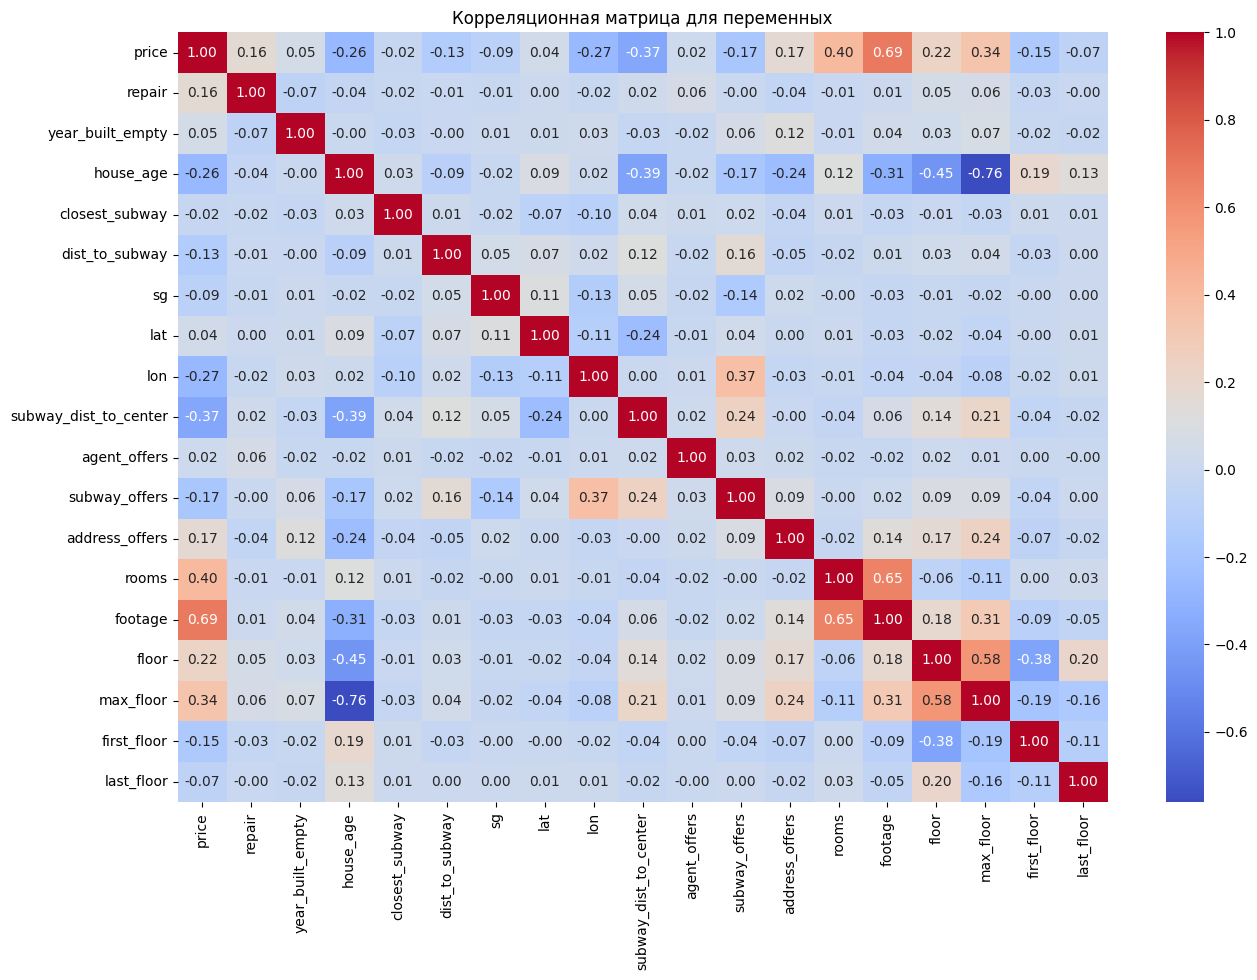

In [319]:
correlation_df: DataFrame = df_copy.drop(['AO', 'hm', 'h3'], axis=1)

# Вычисление коэффициентов корреляции
correlation_matrix:float = correlation_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица для переменных')
plt.show()

На тепловой карте корреляционной матрицы представлены коэффициенты корреляции Пирсона между различными переменными в нашем датасете. Вот некоторые ключевые наблюдения:

    Корреляция с ценой (price):
        Площадь квартиры (footage) имеет сильную положительную корреляцию с ценой. Это означает, что с увеличением площади квартиры, как правило, увеличивается и её цена.
        Количество комнат (rooms) также положительно коррелирует с ценой, что логично, так как больше комнат обычно означает большую площадь.
        Расстояние до метро (dist_to_subway) имеет отрицательную корреляцию с ценой, что может указывать на то, что квартиры, расположенные ближе к метро, стоят дороже.

    Другие интересные корреляции:
        Возраст дома (house_age) имеет отрицательную корреляцию с ценой, что может говорить о том, что более новые квартиры стоят дороже.
        Этаж (floor) и максимальный этаж в здании (max_floor) имеют положительную корреляцию, что может отражать предпочтения покупателей квартир на более высоких этажах.

## Предобработка данных

### Очистка данных от выбросов

In [320]:
def remove_useless_information(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Before {df.shape[0]}")
for column in numeric_columns:
    df = remove_useless_information(df, column)
print(f"After {df.shape[0]}")

df.describe()

Before 12181
After 10930


,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,agent_offers,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor
count,1.093000e+04,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.000000,10930.00000,10930.000000
mean,1.061889e+07,2.258280,0.013541,38.243916,100.835590,870.540988,0.243641,55.736962,37.621234,11928.280421,25.737328,10.027539,1.250229,1.602653,45.337712,6.175114,12.530009,0.11226,0.093596
std,2.781350e+06,0.755852,0.115579,20.455652,56.628848,443.851003,0.634808,0.087386,0.132821,4706.914577,62.294293,7.084543,0.652187,0.489371,9.736072,4.295845,5.342704,0.31570,0.291279
min,4.900000e+06,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,55.527631,37.336921,1133.000000,0.000000,1.000000,1.000000,1.000000,30.100000,1.000000,2.000000,0.00000,0.000000
25%,8.450000e+06,2.000000,0.000000,20.000000,53.000000,542.000000,0.000000,55.673295,37.524353,8480.000000,1.000000,5.000000,1.000000,1.000000,38.000000,3.000000,9.000000,0.00000,0.000000
50%,1.000000e+07,2.000000,0.000000,44.000000,104.000000,797.000000,0.000000,55.725930,37.609367,12418.000000,1.000000,8.000000,1.000000,2.000000,44.000000,5.000000,12.000000,0.00000,0.000000
75%,1.230000e+07,3.000000,0.000000,54.000000,149.000000,1136.000000,0.000000,55.805758,37.722729,14840.000000,11.000000,13.000000,1.000000,2.000000,52.400000,9.000000,17.000000,0.00000,0.000000
max,1.900000e+07,4.000000,1.000000,109.000000,199.000000,2127.000000,3.000000,55.941577,37.950668,24636.000000,292.000000,40.000000,7.000000,2.000000,75.500000,18.000000,29.000000,1.00000,1.000000


### Кодирование Категориальных Переменных

    One-Hot Encoding: Преобразует категориальные переменные в набор бинарных столбцов, каждый из которых указывает на присутствие или отсутствие каждой возможной категории. Это подходит для переменных с небольшим числом уникальных категорий.

    Label Encoding: Присваивает каждой уникальной категории числовой метки. Это эффективно для переменных с большим количеством категорий, где one-hot encoding может привести к слишком большому увеличению размерности.

#### Рассмотрим каждую переменную:

    h3: Учитывая большое количество уникальных значений, предпочтительнее использовать Label Encoding.
    AO: Количество уникальных значений умеренное, можно использовать One-Hot Encoding.
    hm: Также подходит для One-Hot Encoding.
    year_built_empty: Учитывая только два уникальных значения, можно использовать One-Hot Encoding или просто оставить как бинарный столбец.

In [321]:
label_encoder = LabelEncoder()
# df['h3_encoded'] = label_encoder.fit_transform(df['h3'])
df['h3'] = label_encoder.fit_transform(df['h3'])

# One-Hot Encoding для 'AO', 'hm', и 'year_built_empty'
df = pd.get_dummies(df, columns=['AO', 'hm', 'year_built_empty'])

df.head()

,price,repair,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,h3,...,AO_UVAO,AO_UZAO,AO_VAO,AO_ZAO,hm_block,hm_brick,hm_monolith,hm_panel,year_built_empty_0,year_built_empty_1
0,8000000,3,42,59,960,0.0,55.609009,37.734632,17166,3,...,False,False,False,False,False,False,False,True,True,False
1,7200000,2,43,59,802,0.0,55.608760,37.741936,17166,1,...,False,False,False,False,False,False,False,True,True,False
2,10300000,2,43,59,638,0.0,55.610207,37.742495,17166,1,...,False,False,False,False,False,False,False,True,True,False
3,8500000,2,43,59,929,0.0,55.624017,37.740373,17166,3,...,False,False,False,False,False,False,False,True,True,False
4,9000000,2,43,59,785,0.0,55.609107,37.740430,17166,1,...,False,False,False,False,False,False,False,True,True,False


#### Нормализация и стандартизация(Z-оценка) числовых переменных

In [322]:
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Просмотр измененных данных
scaled_data_description = df[numeric_columns].describe()
scaled_data_description

,price,house_age,dist_to_subway,footage,floor,max_floor
count,1.093000e+04,1.093000e+04,1.093000e+04,1.093000e+04,1.093000e+04,1.093000e+04
mean,-2.080272e-16,6.078293e-17,-4.160543e-17,-3.224421e-16,3.705484e-17,1.040136e-16
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-2.056250e+00,-1.869687e+00,-1.936642e+00,-1.565150e+00,-1.204734e+00,-1.971004e+00
25%,-7.798327e-01,-8.919173e-01,-7.402394e-01,-7.536969e-01,-7.391468e-01,-6.607461e-01
50%,-2.225240e-01,2.814062e-01,-1.656960e-01,-1.374038e-01,-2.735593e-01,-9.920696e-02
75%,6.044503e-01,7.702910e-01,5.981087e-01,7.254067e-01,6.576157e-01,8.366916e-01
max,3.013462e+00,3.459158e+00,2.830942e+00,3.098135e+00,2.752759e+00,3.082848e+00


## Обучения и оценки модели

#### Разделение данных на обучающую и тестовую выборку

In [323]:
X = df.drop('price', axis=1)
Y = df['price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Мы указываем test_size=0.2 для сохранения 20% данных для тестирования.

# Проверка размеров полученных выборок
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8744, 33), (2186, 33), (8744,), (2186,))

#### <b>Этап моделирования и оценки модели</b>

<b>Реализуем три модели</b>

    Линейная регрессия (Linear Regression): Базовая и часто используемая модель для регрессионных задач.
    Случайный лес (Random Forest Regression): Модель, которая строит множество решающих деревьев и выдает средний результат их прогнозов.

    Градиентный бустинг (Gradient Boosting Regression): Модель последовательно строит решающие деревья, каждое из которых участвует в корректировке ошибок предыдущих деревьев.

MSE в ML означает среднеквадратичную ошибку (mean squared error), которая является метрикой регрессии, измеряющей среднюю квадратичную разницу между фактическими и прогнозируемыми значениями. MSE показывает, насколько хорошо модель соответствует данным, и чем ниже MSE, тем лучше модель.

In [324]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    print(f"{name}: MSE = {mse}")

Linear Regression: MSE = 0.19238439454976608


Random Forest: MSE = 0.11555174214695363
Gradient Boosting: MSE = 0.1542676617178789


In [325]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Создание модели градиентного бустинга
gb = GradientBoostingRegressor(random_state=42)

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)

# Лучшие параметры и соответствующая ошибка
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая MSE: {best_score}")

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Лучшая MSE: 0.12278061354767955


MSE на тестовой выборке: 0.11252366622559377


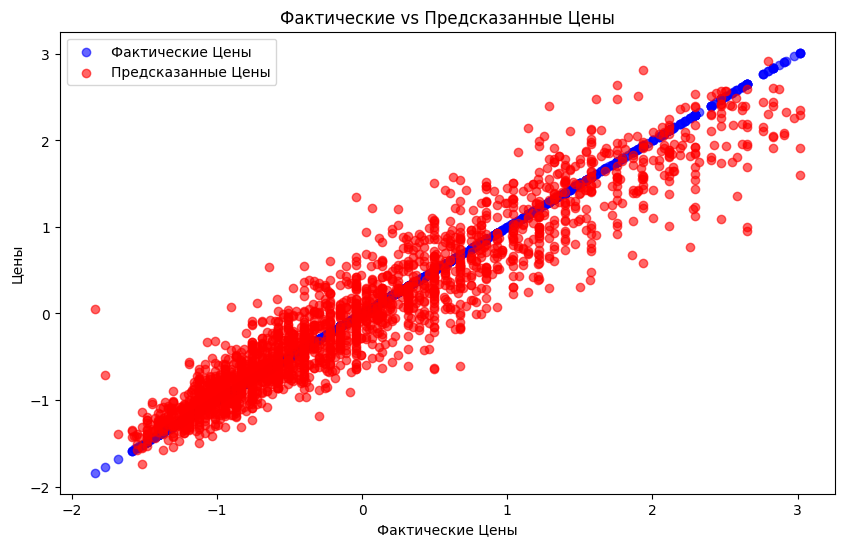

In [328]:
best_gb_model = grid_search.best_estimator_
predictions = best_gb_model.predict(X_test)

mse = mean_squared_error(Y_test, predictions)

print(f"MSE на тестовой выборке: {mse}")

plt.figure(figsize=(10, 6))

# Фактические цены
plt.scatter(Y_test, Y_test, alpha=0.6, color='blue', label='Фактические Цены')

# Предсказанные цены
plt.scatter(Y_test, predictions, alpha=0.6, color='red', label='Предсказанные Цены')

plt.xlabel('Фактические Цены')
plt.ylabel('Цены')
plt.title('Фактические vs Предсказанные Цены')
plt.legend()
plt.show()

#### Все модели

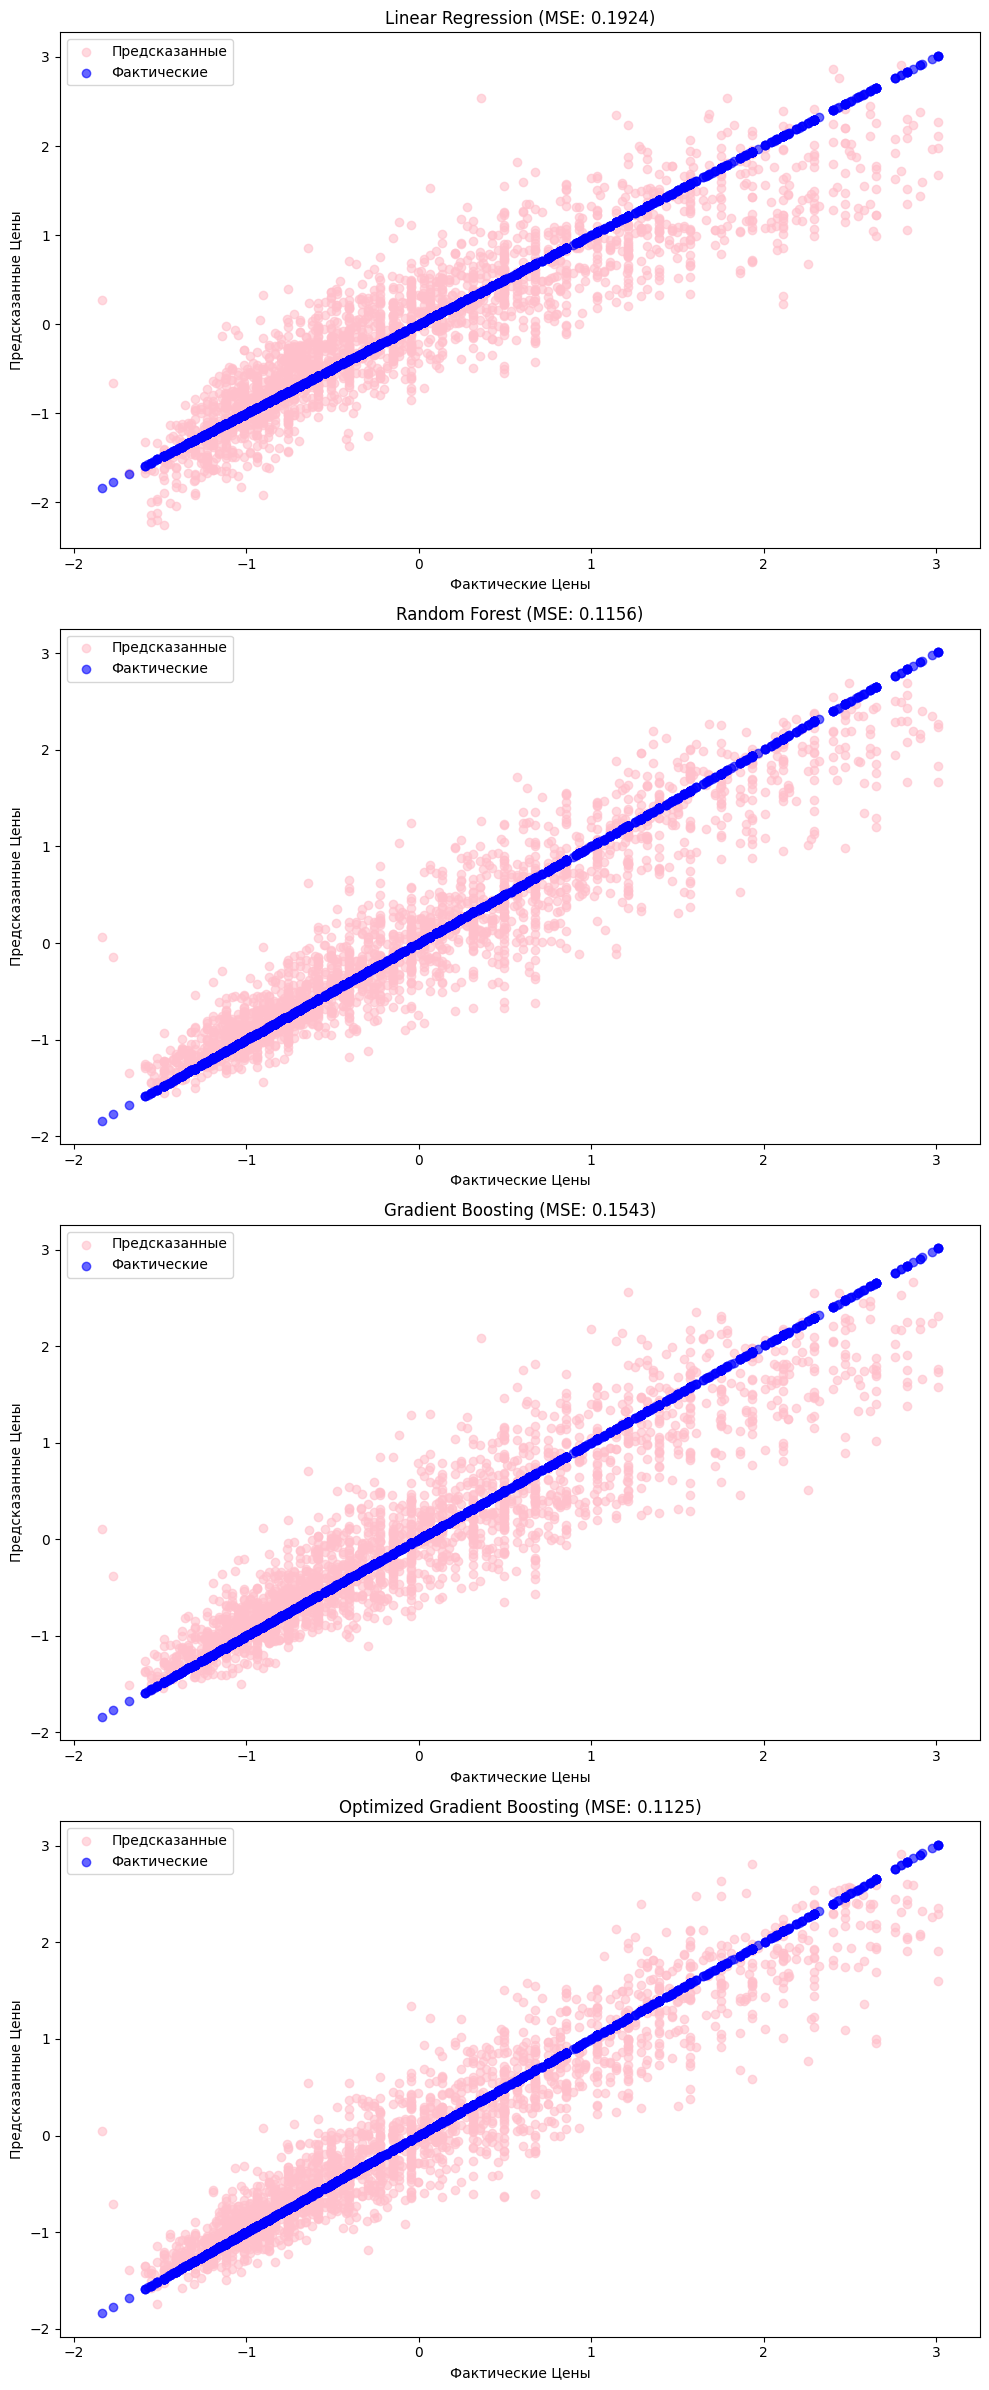

In [330]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Optimized Gradient Boosting": grid_search.best_estimator_  # Используем лучший градиентный бустинг
}

fig, axes = plt.subplots(len(models), 1, figsize=(10, 6 * len(models)))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, predictions)
    
    axes[i].scatter(Y_test, predictions, alpha=0.6, color='pink', label='Предсказанные')
    axes[i].scatter(Y_test, Y_test, alpha=0.6, color='blue', label='Фактические')
    axes[i].set_title(f"{name} (MSE: {mse:.4f})")
    axes[i].set_xlabel('Фактические Цены')
    axes[i].set_ylabel('Предсказанные Цены')
    axes[i].legend()

plt.tight_layout()
plt.show()